# The impact of the day zero drought on vegetation on the Western Cape

#### To run this analysis you need access to google earth engine. If you do not have access please sign up for a free account [here](https://signup.earthengine.google.com/])

## Setup libraries

In [1]:
import sys
sys.path.append("src")
import uuid
import shutil
import ee
import folium
import geopandas as gpd
import rtree
import numpy as np
import pandas as pd
import math
import datetime
import rasterio as rio
from rasterio.plot import show
import matplotlib.pyplot as plt
import altair as alt
#helper functions for usinng gee
from gee_modis_clean import getQABits, updateMultipleMask
from gee_linear_model import addDependents, addHarmonics, constructBandNames, predict_coeffs, diff_predict
from gee_folium import add_ee_layer

In [2]:
#Authenticate Earth Engine 
#NB!!! right click and open this link in a new tab
ee.Authenticate()

Enter verification code: 4/uAFY7FmcnYOXFfJ3EByJxzYue6qG2n2lze2228icSvjducJiVHwcrQY

Successfully saved authorization token.


In [3]:
# Initialize the Earth Engine module.
ee.Initialize()

In [ ]:
# Test if earth engine is working by printing metadata for a DEM dataset.
print(ee.Image('USGS/SRTMGL1_003').getInfo())

## Read in raw data and clip to regions of interest
We select 3 biomes - renosterveld, fynbos, and forest- and 2 agricultural land uses - irrigated vineyards and rainfed grains.  
Biomes are masked with layers of naturla vegetation remnants and protected areas. 
We then extract these land uses in three regions

In [75]:
#vegmap2018
#http://bgis.sanbi.org/SpatialDataset/Detail/1674
vegmap = gpd.read_file('data/vegmap2018/vegmap2018_wc.shp')

#wc protected areas
#http://bgis.sanbi.org/SpatialDataset/Detail/649
wcpa = gpd.read_file('data/WCBSP_PA_2017/BSP_PA_2017.shp')
wcpa= wcpa[['Name','geometry']]

#wc natural
#from CapeNature. email: Therese Forsyth <tforsyth@capenature.co.za>
remnants = gpd.read_file('data/remnants/natrem.shp')
remnants = remnants[['OBJECTID','Condition','geometry']]

#wc crop types
#from WC department of Agricultre. email: FC Basson <FCBasson@elsenburg.com>
crops = gpd.read_file('data/wc_crops_2013/Crop_Census_2013.shp')
crops = crops[['FIELD_ID','CROPS','CR_SUM','DRY_IRR','geometry']]

#regions
#manually created regions of interest
regions = gpd.read_file('data/regions/regions.shp')

In [76]:
#filter BIOREGION_
bregions = ['Northwest Fynbos Bioregion','Southern Fynbos Bioregion',\
            'Southwest Fynbos Bioregion','West Coast Renosterveld Bioregion',\
            'East Coast Renosterveld Bioregion','Zonal & Intrazonal Forests',\
           'Azonal Forests']
vegmap = vegmap[vegmap['BIOREGION_'].isin(bregions)]

#recode as biomes
dict = {'Northwest Fynbos Bioregion' : 'Fy', 'Southern Fynbos Bioregion' : 'Fy', \
        'Southwest Fynbos Bioregion' : 'Fy', \
        'West Coast Renosterveld Bioregion' : 'R','East Coast Renosterveld Bioregion' : 'R',\
        'Zonal & Intrazonal Forests' : 'Fo', 'Azonal Forests' : 'Fo'} 
vegmap['biome']= vegmap['BIOREGION_'].map(dict) 

vegmap = vegmap[['OBJECTID','BIOREGION_','Name_18', 'biome','geometry']]

#filter remnants
remnants = remnants[remnants['Condition']=='Natural']

#grapes
grapes = crops[(crops['CR_SUM']=='Grapes') & (crops['DRY_IRR']=='Irrigated')] 
grapes['biome']="V"
#wheat
wheat = crops[(crops['CR_SUM']=='Grains') & (crops['DRY_IRR']=='Dry land')]
wheat['biome']="G"

/anaconda3/envs/dayzero/lib/python3.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/anaconda3/envs/dayzero/lib/python3.7/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [77]:
#reproject
vegmap = vegmap.to_crs({'init': 'epsg:4326'})
remnants = remnants.to_crs({'init': 'epsg:4326'})
regions = regions.to_crs({'init': 'epsg:4326'})

In [ ]:
veg_r = gpd.overlay(wcpa, regions, how='intersection')
veg_r = gpd.overlay(remnants,veg_r, how='intersection')
veg_r = gpd.overlay(vegmap,veg_r, how='intersection')
grape_r = gpd.overlay(grapes, regions, how='intersection')
wheat_r = gpd.overlay(wheat, regions, how='intersection')

In [ ]:
#veg_r.to_file('veg_r.shp')
#grape_r.to_file('gr.shp')
#wheat_r.to_file('wr.shp')

In [ ]:
veg_r = veg_r[['OBJECTID_1','Name_18','biome','rname','geometry']]
grape_r = grape_r[['FIELD_ID','CROPS','biome','rname','geometry']]
wheat_r = wheat_r[['FIELD_ID','CROPS','biome','rname','geometry']]

dict= {"FIELD_ID":"OBJECTID_1", "CROPS": "Name_18", "biome":"biome", "rname":"rname", "geometry":"geometry"}
grape_r = grape_r.rename(columns=dict)
wheat_r = wheat_r.rename(columns=dict)

In [ ]:
all_r = veg_r.append(grape_r).append(wheat_r)
all_r['code'] = all_r['rname'] + '_' + all_r['biome']

In [5]:
#dissolve
all_r = all_r.dissolve(by='code', aggfunc='first')\
    .reset_index(level=0, inplace=True)
#convert to utm so unit is meters
all_r_utm =all_r.to_crs({'init': 'epsg:32734'})
#buffer by 125 meters
all_r_utm['geometry'] = all_r_utm.geometry.buffer(-125)
#polyarea
all_r_utm["area"] = all_r_utm['geometry'].area
#remove empty
all_r_utm = all_r_utm[all_r_utm["area"]>0]
#return to WGS
all_r =all_r_utm.to_crs({'init': 'epsg:4326'})

## Visualize the extracted areas

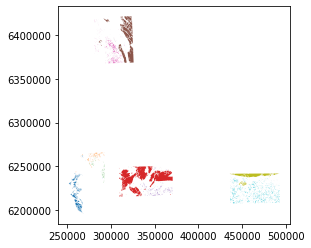

In [33]:
fig, ax = plt.subplots(1, 1)
all_r_utm.plot(column='code',
            ax=ax)

In [ ]:
## Write results to file and zip

In [37]:
all_r.to_file('output/all_r.shp')
shutil.make_archive('all_r', 'zip', 'output')

'/Users/glenn/day_zero/all_r.zip'

In [71]:
all_r = gpd.read_file('output/all_r.shp')

In [72]:
all_r_utm =all_r.to_crs({'init': 'epsg:32734'})
all_r_utm['geometry'] = all_r_utm.geometry.buffer(-125)

In [73]:
#polyarea
all_r_utm["area"] = all_r_utm['geometry'].area
#remove empty
all_r_utm = all_r_utm[all_r_utm["area"]>0]

In [74]:
all_r.describe()

,OBJECTID_1,area
count,18.000000,1.800000e+01
mean,43709.666667,8.534673e+07
std,50344.699380,1.760505e+08
min,2.000000,4.451077e+03
25%,2914.750000,4.610909e+05
50%,36658.500000,4.754521e+06
75%,47654.750000,9.674388e+07
max,197733.000000,6.838184e+08


In [ ]:
#dissolve
all_r = all_r.dissolve(by='code', aggfunc='first')\
    .reset_index(level=0, inplace=True)
#convert to utm so unit is meters
all_r_utm =all_r.to_crs({'init': 'epsg:32734'})
#buffer by 125 meters
all_r_utm['geometry'] = all_r_utm.geometry.buffer(-125)
#polyarea
all_r_utm["area"] = all_r_utm['geometry'].area
#remove empty
all_r_utm = all_r_utm[all_r_utm["area"]>0]
#return to WGS
all_r =all_r_utm.to_crs({'init': 'epsg:4326'})

### Upload to GEE
sure we could do thisusing a bunch of command line tools and google cloud storage, but it is easier for you to ust download `all_r.zip` and upload it manually to GEE

### The Earth engine bit

In [38]:
# read in polygons and rasterize
area = ee.FeatureCollection("users/glennwithtwons/allr")

def recode(feature):
    num = ee.Number.parse(feature.get('code'))
    return feature.set('codeint', num)

area = area.map(recode)

areaRas = area \
  .filter(ee.Filter.notNull(['codeint'])) \
  .reduceToImage(properties = ['codeint'],reducer = ee.Reducer.first()) \
  .rename(['codeint']) \
  .reproject('SR-ORG:6974')

#create mask
areaMask = area \
  .filter(ee.Filter.notNull(['codeint'])) \
  .map(lambda feature: feature.set('flag', ee.Number(1))) \
  .reduceToImage(['flag'],ee.Reducer.first()) \
  .rename(['flag'])

In [39]:
# The number of cycles per year to model.
harmonics = 1
index= 'NDVI'

# Make a list of harmonic frequencies to model.
# These also serve as band name suffixes.
harmonicFrequencies = ee.List.sequence(1, harmonics)
harmonicFrequencies_st = list(range(1,harmonics+1))

# Construct lists of names for the harmonic terms.
cosNames = constructBandNames('cos_', harmonicFrequencies_st)
sinNames = constructBandNames('sin_', harmonicFrequencies_st)

# Independent variables = intercept, time, and kernel mean
independents = ee.List(['constant','t']) \
  .cat(cosNames).cat(sinNames)

In [40]:
#get data
col_tr = ee.ImageCollection('MODIS/006/MYD13Q1')\
  .merge(ee.ImageCollection('MODIS/006/MOD13Q1'))\
  .filterBounds(area)\
  .filterDate('2000-01-01', '2014-12-31')\
  .map(updateMultipleMask(index,areaMask)) \
  .select(index)\
  .map(addDependents) \
  .map(addHarmonics(harmonicFrequencies,cosNames,sinNames))

col_val = ee.ImageCollection('MODIS/006/MYD13Q1')\
  .merge(ee.ImageCollection('MODIS/006/MOD13Q1'))\
  .filterBounds(area)\
  .filterDate('2001-01-01', '2019-12-31')\
  .map(updateMultipleMask(index,areaMask)) \
  .select(index)\
  .map(addDependents) \
  .map(addHarmonics(harmonicFrequencies,cosNames,sinNames))
   

In [41]:
# The dependent variable we are modeling.
dependents = ee.List([index])

#fit the regression
# The output of the regression reduction is a 4x1 array image.
harmonicTrend_tr = col_tr.select(independents.cat(dependents)).reduce(ee.Reducer.robustLinearRegression(independents.length(), 1))
# Turn the array image into a multi-band image of coefficients.
hTC = harmonicTrend_tr.select('coefficients').arrayProject([0]).arrayFlatten([independents])
#RMSE
hResid = harmonicTrend_tr.select('residuals').arrayFlatten([dependents])

In [42]:
#make predictions on data using fitted model
#then transform imgCol to multiband img
col_val_fit = col_val \
      .map(predict_coeffs(independents,hTC))\
      .map(diff_predict(index))\
      .sort('system:time_start', False) \
      .map(lambda image: image.select(['fitted'])) \
      .toBands() \
      .toFloat()

col_val_raw = col_val \
      .sort('system:time_start', False) \
      .map(lambda image: image.select([index])) \
      .toBands() \
      .toFloat()

col_exp = areaRas \
  .toFloat() \
  .addBands(col_val_fit)\
  .addBands(col_val_raw)\
  .addBands(ee.Image.pixelLonLat())\
  .toFloat() 

In [61]:
#dates and names of bands
ndname = col_exp.getInfo()
ndvi_id = pd.DataFrame(ndname.get('bands'))['id']

In [62]:
ndvi_id

0                   codeint
1       2_2019_11_17_fitted
2       1_2019_11_09_fitted
3       2_2019_11_01_fitted
4       1_2019_10_24_fitted
               ...         
1668      2_2001_02_02_NDVI
1669      2_2001_01_17_NDVI
1670      2_2001_01_01_NDVI
1671              longitude
1672               latitude
Name: id, Length: 1673, dtype: object

In [63]:
#export task
task = ee.batch.Export.image.toDrive(image=col_exp,
                                     region=area.geometry(),
                                     description='ndras_all',
                                     scale=250)
task.start()

In [70]:
#check on task
task.status()

{'state': 'RUNNING',
 'description': 'ndras_all',
 'creation_timestamp_ms': 1576050385254,
 'update_timestamp_ms': 1576050411023,
 'start_timestamp_ms': 1576050410732,
 'task_type': 'EXPORT_IMAGE',
 'id': '3R5ONGP6DTT7GHWG2MXNSOUW',
 'name': 'projects/earthengine-legacy/operations/3R5ONGP6DTT7GHWG2MXNSOUW'}

In [11]:
im = col_val_fit.select(['1_2019_11_09_fitted'])

# Set visualization parameters.
vis_params = {
  'min': 0,
  'max': 8000,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
    '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
    '012E01', '011D01', '011301']}

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map object.
my_map = folium.Map(location=[-33.98,18.39], zoom_start=10)

# Add the ndvi to the map object.
my_map.add_ee_layer(im, vis_params, 'map')
#my_map.add_ee_layer(area, vis_params, 'map')
# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

KeyboardInterrupt: 